# <b> Twitter Sentiment Analysis </b>

In [ ]:
!pip install --upgrade gensim
!pip install pyldavis

In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
import string
import re
import sys
import pickle as pkl
from nltk.corpus import stopwords
import collections
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
import gensim.corpora as corpora
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models
import os

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<h2><b> 1. Data preprocessing/cleanup </b></h2>
We have to firstly read the .pkl file and save the data in a dataframe.
Then we convert all the tweets into lowercase and remove stopwords, URLs,
hashtags, @, punctuation and emojis.

In [6]:
# Question 1

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Read .pkl file
df = pd.read_pickle('/content/drive/MyDrive/ΤΕΔΕ/eclass_all_with_sentiment_v2.pkl')

# Set to lowercase
df = df.apply(lambda x: x.astype(str).str.lower())

# Remove stopwords
df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

# Remove URLs
df["text"] = df["text"].apply(lambda x: re.split(r'https:\/\/.*', str(x))[0])

# Remove hashtags ('#')
df["text"] = df["text"].apply(lambda x: re.sub("#[A-Za-z0-9_]+","", str(x)))

# Remove ats ('@')
df["text"] = df["text"].apply(lambda x: re.sub("@[A-Za-z0-9_]+","", str(x)))

# Remove punctuation
df["text"] = df["text"].str.translate(str.maketrans('','',string.punctuation))


# Remove emojis
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

<h3><b> Creating training and test sets </b></h3>
Training set: 80% of data
<br>
Test set: 20% of data
<br>
After we split the data we save it in two files, 'train.tsv' and 'test.tsv'

In [7]:
# The percentage of the dataset that will be used for training the estimators
df_size = int(len(df)*0.2)

# Spliting dataframe in training and test sets
train_size = int(df_size*0.8)
test_size = df_size - train_size

tf_train = df.iloc[:train_size]
tf_test = df.iloc[train_size:df_size]

tf_train.to_csv('train.tsv',  index = False , sep="\t")
tf_test.to_csv('test.tsv', index = False, sep="\t")

-----

<h2><b> 2. Analyzing the data </b></h2>
<h3><b> Number of positive/negative/neutral tweets </b></h3>
The first thing we do is to find how many positive, negative and neutral tweets
there are in total.

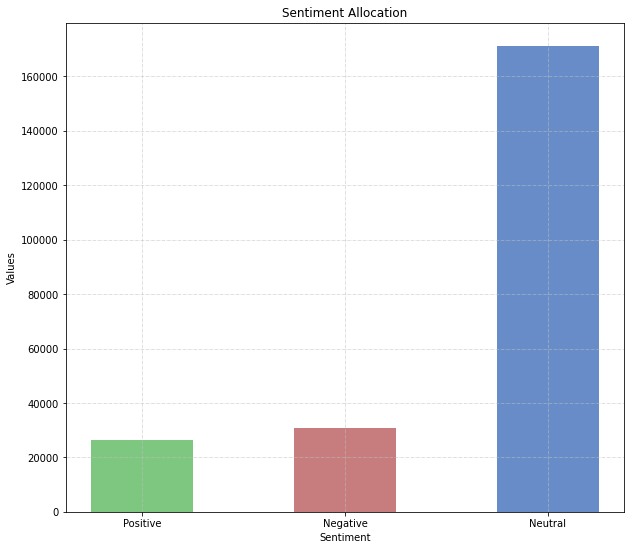

In [8]:
# Question 2 Sub-question i)

pos = 0 
neg = 0
neut = 0

# Count the occurences of every sentiment in the 'sentiment' column of the dataframe
last_column = df.iloc[: , -1]
for val in last_column:
  if(val == "pos"):
    pos+=1
  elif(val == "neg"):
    neg+=1
  elif(val == "neu"):
    neut+=1

# Create the dataset
data = {'Positive':pos, 'Negative':neg, 'Neutral':neut}
sentiment = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 9))
 
# Create a bar plot
plt.bar(sentiment[0], values[0], color ='#7dc781', width = 0.5)
plt.bar(sentiment[1], values[1], color ='#c77d7d', width = 0.5)
plt.bar(sentiment[2], values[2], color ='#678cc7', width = 0.5)

plt.xlabel("Sentiment")
plt.ylabel("Values")
plt.title("Sentiment Allocation")

plt.grid(linestyle='-.', linewidth=0.5 , color='silver', fillstyle='full')
plt.show()

<h3><b> Most common words used in tweets </b></h3>
We find the words that appear most frequently.

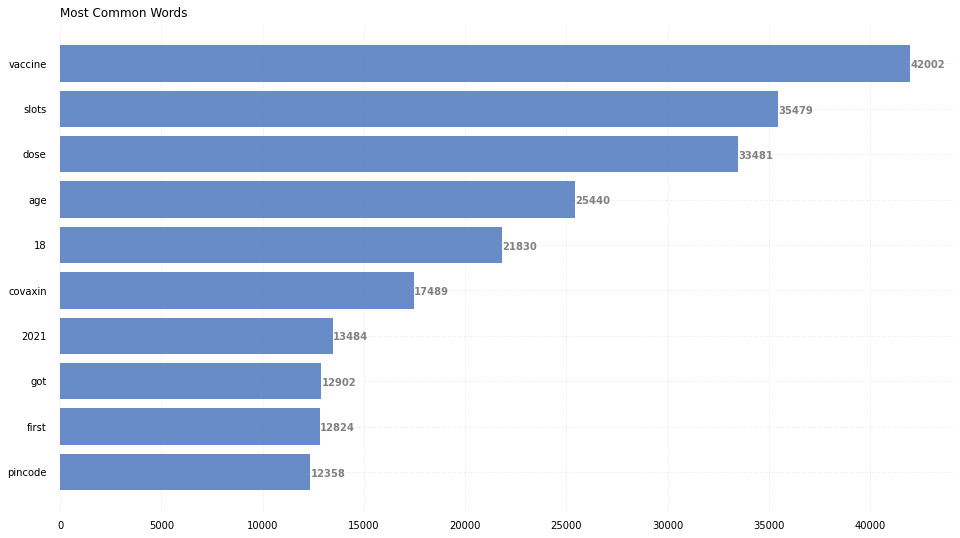

In [9]:
# Question 2 Sub-question ii)

# The maximum number of common words that will be displayed
max_display = 10

# Get all the words from the dataset
words = []
for row in df["text"]:
  word = row.split()
  words.extend(word)

# Get the words that appear more frequently
counter = collections.Counter(words)
most_common_words = counter.most_common(max_display)
common_dict = dict(most_common_words)

# Create a bar plot to show the most common words
fig, ax = plt.subplots(figsize =(16, 9))
 
ax.barh(list(common_dict.keys()), list(common_dict.values()), color="#678cc7")

# Make some small changes to the bar plot's appearance
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
 
# Show higher values first
ax.invert_yaxis()
 
# Add the values next to the bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 10, fontweight ='bold', color ='grey')
 
ax.set_title('Most Common Words', loc ='left')

plt.show()

<h3><b> Most common words in positive, negative and neutral tweets </b></h3>
We find the words that appear most frequently in each category of tweets.


In [10]:
# Function that makes a custom bar plot
def BarGraphFunction(width, height, y_values, x_values, title, bar_color, x_label, y_label):
  
  fig, ax = plt.subplots(figsize =(width, height))
  
  ax.barh(x_values, y_values, color = bar_color)
  
  # Make some small changes to the bar plot's appearance
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)
  
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)
  
  ax.grid(b = True, color ='white',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)
  
  # Show higher values first
  ax.invert_yaxis()
  
  # Show the value of each bar
  for i in ax.patches:
      plt.text(i.get_width()-50, i.get_y()+0.5,
              str(round((i.get_width()), 2)),
              fontsize = 10, fontweight ='bold', ha='right', color='white')
  
  ax.set_facecolor('#2e2e2e')
  ax.tick_params(colors='white', which='both')
  fig.patch.set_facecolor('#2e2e2e')
  ax.set_title(title, fontsize=16, loc ='left', fontweight ='bold' , color='white')
  plt.xlabel(x_label, fontweight ='bold', color='grey')
  plt.ylabel(y_label, fontweight ='bold', color='grey')

  plt.show()

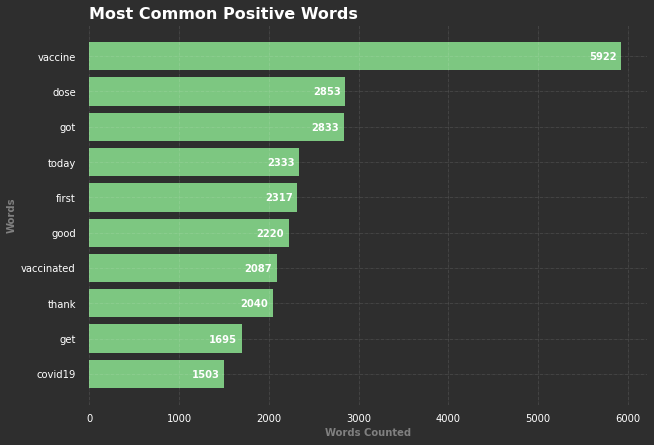

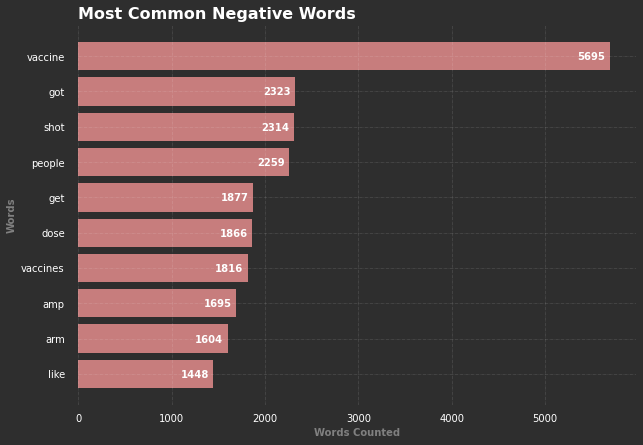

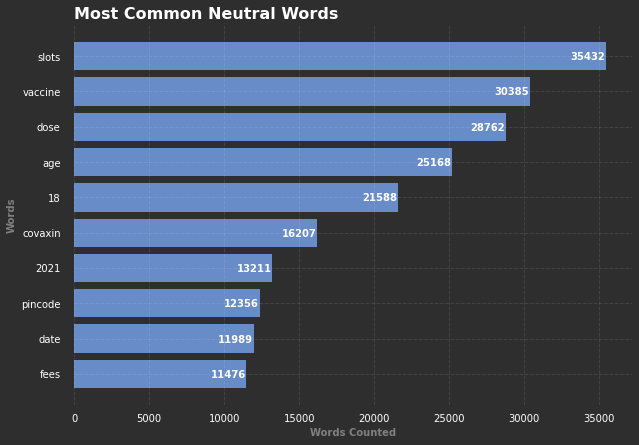

In [11]:
# Question 2 Sub-question iii)

# The maximum number of common words that will be displayed
max_display = 10
i = 0

pos_words = []
neg_words = []
neut_words = []

last_column = df.iloc[: , -1]

# Get all the words from every category of tweets
for row in df["text"]:
  if(last_column[i] == "pos"):
    pos_word = row.split()
    pos_words.extend(pos_word)
  elif(last_column[i] == "neg"):
    neg_word = row.split()
    neg_words.extend(neg_word)
  elif(last_column[i] == "neu"):
    neut_word = row.split()
    neut_words.extend(neut_word)
  i=i+1

# Get the words that appear more frequently in positive tweets
counter_pos = collections.Counter(pos_words)
most_common_positive_words = counter_pos.most_common(max_display)
pos_common_dict = dict(most_common_positive_words)

# Get the words that appear more frequently in negative tweets
counter_neg = collections.Counter(neg_words)
most_common_negative_words = counter_neg.most_common(max_display)
neg_common_dict = dict(most_common_negative_words)

# Get the words that appear more frequently in neutral tweets
counter_neut = collections.Counter(neut_words)
most_common_neutral_words = counter_neut.most_common(max_display)
neut_common_dict = dict(most_common_neutral_words)

# Create bar plots to show the most common words
BarGraphFunction(10, 7, list(pos_common_dict.values()), list(pos_common_dict.keys()), "Most Common Positive Words", "#7dc781", "Words Counted", "Words")
BarGraphFunction(10, 7, list(neg_common_dict.values()), list(neg_common_dict.keys()), "Most Common Negative Words", "#c77d7d", "Words Counted", "Words")
BarGraphFunction(10, 7, list(neut_common_dict.values()), list(neut_common_dict.keys()), "Most Common Neutral Words", "#678cc7", "Words Counted", "Words")

<h3><b> Tweets that contain the names of the vaccines </b></h3>
We create a subset of tweets that contain the word 'astrazeneca' and another subset of tweets that contain the words 'moderna', 'pfizer' or 'biontech'.
<br>
Then we compare the two subsets based on how many positive, negative and neutral tweets they contain.

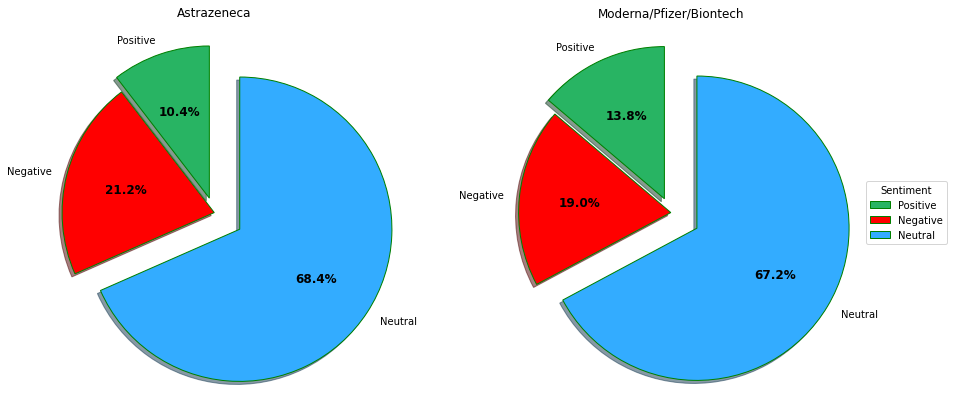

In [12]:
# Question 2 Sub-question iv)

astraPos, astraNeg, astraNeu = 0, 0, 0
modPfizPos, modPfizNeg, modPfizNeu = 0, 0, 0
vaccNames = ["moderna", "pfizer", "biontech"]

# For every tweet that contains the words "astrazeneca" or "moderna"/"pfizer"/"biontech" check the sentiment of that tweet
for row in df.itertuples():
  if "astrazeneca" in row.text:
    if row.sentiment == "pos":
      astraPos+=1
    if row.sentiment == "neg":
      astraNeg+=1
    if row.sentiment == "neu":
      astraNeu+=1
  if any(vacc in row.text for vacc in vaccNames):
    if row.sentiment == "pos":
      modPfizPos+=1
    if row.sentiment == "neg":
      modPfizNeg+=1
    if row.sentiment == "neu":
      modPfizNeu+=1

# Create two pie charts to show the sentiment of the tweets that contain these specific words
sent = ['Positive', 'Negative', 'Neutral']
 
data1 = [astraPos, astraNeg, astraNeu]
data2 = [modPfizPos, modPfizNeg, modPfizNeu] 

explode = (0.1, 0.0, 0.2)
 
colors = ("#28B463", "red", "#33ACFF")

wp = {'linewidth' : 1, 'edgecolor' : "green"}

# Pie chart for the tweets that contain the word "astrazeneca"
plt.subplot(1,2,1)
wedges, texts, autotexts = plt.pie(data1,
                                  explode = explode,
                                  labels = sent,
                                  autopct='%1.1f%%',
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp)

plt.setp(autotexts, size = 12, weight ="bold")
plt.title("Astrazeneca")

# Pie chart for the tweets that contain the words "moderna", "pfizer" or "biontech"
plt.subplot(1,2,2)
wedges, texts, autotexts = plt.pie(data2,
                                  explode = explode,
                                  labels = sent,
                                  autopct='%1.1f%%',
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp)

plt.setp(autotexts, size = 12, weight ="bold")
plt.title("Moderna/Pfizer/Biontech")

plt.legend(wedges, sent,
          title ="Sentiment",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

fig = plt.gcf()
fig.set_size_inches(15, 9)

plt.show()

<h3><b> Number of tweets per month </b></h3>
We find how many tweets were posted each month.
<br>
For the months with the most tweets we also mention if any important events happened during these months.

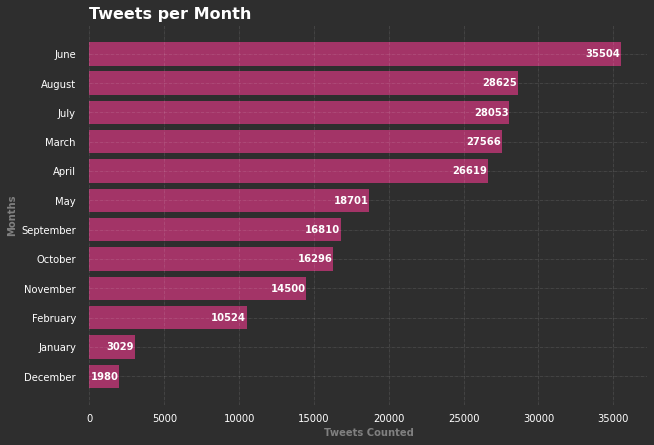

In [13]:
# Question 2 Sub-question v)

count = 0
resultsList = [0]*12
i = 0

# Function that takes a list and increases the value of a specific index by one 
def dynamicAppendList(lista, index, value):
  if not lista:
    lista[index] = value
  else:
    lista[index] = lista[index] + value
  return lista


# For each month we count all the tweets
for row in df.itertuples():
  date_time_formated = row.date.replace("-", "/")
  date_time = datetime.strptime(date_time_formated, '%Y/%m/%d %H:%M:%S')
  res = dynamicAppendList(resultsList, date_time.month-1, 1);
  
# Create a list with all the months
months = []
for month in calendar.month_name:
  if not month:
    continue
  months.append(month)

# Create a dictionary with keys and values of months and tweets 
resDict = {}
for key in months:
    for value in res:
        resDict[key] = value
        res.remove(value)
        break

# Sort the dictionary based on values
sorted_dict = {}
sorted_keys = sorted(resDict, key=resDict.get)  
for w in sorted_keys:
    sorted_dict[w] = resDict[w]

# Get the months with the most tweets
max_months = 12
inverted = {}
for x in list(reversed(list(sorted_dict)))[0:max_months]:
  inverted[x] = sorted_dict[x]

# Create a bar plot that shows the months with the most tweets
BarGraphFunction(10, 7, list(inverted.values()), list(inverted.keys()), "Tweets per Month", "#dc3783ad", "Tweets Counted", "Months")

The results show that more tweets were posted during March, April, June, July and August of 2021 compared to other months. Some important events that happened during these months are the following:
<br> <br>
<u><b> March 2021 </u></b>: Several countries suspend dispensing the AstraZeneca COVID-19 vaccine over concerns of blood clotting.
<br>
<u><b> April 2021 </u></b>: CDC recommends pausing the use of the Johnson & Johnson (J&J) COVID-19 vaccine because of blood clot complications. CDC also announces that fully vaccinated individuals can travel safely domestically in the U.S. without a COVID test first.
<br>
<u><b> June 2021 </b></u>: The delta variant becomes the dominant variant in the United States. The variant kicks off a third wave of infections during the summer of 2021.
<br>
<u><b> July 2021 </u></b>: The FDA warns that the COVID-19 vaccine manufactured by Johnson & Johnson (J&J) can lead to an increased risk of Guillain-Barré syndrome. Also, new research shows that the Pfizer vaccine is not as effective against the delta variant.
<br>
<u><b> August 2021 </u></b>: Pfizer/BioNTech vaccine gains full FDA approval and vaccine mandates for workers are announced in the United States.
<br> <br>
<b> Sources: </b>
<br> https://www.cdc.gov/museum/timeline/covid19.html
<br> https://www.ajmc.com/view/a-timeline-of-covid-19-vaccine-developments-in-2021
<br> https://www.ajmc.com/view/a-timeline-of-covid-19-vaccine-developments-for-the-second-half-of-2021
<br> <br>
<hr>


<h3><b> Average number of favorites and retweets </b></h3>
We will compare the average number of favorites and retweets that a positive, negative or neutral tweet gets.

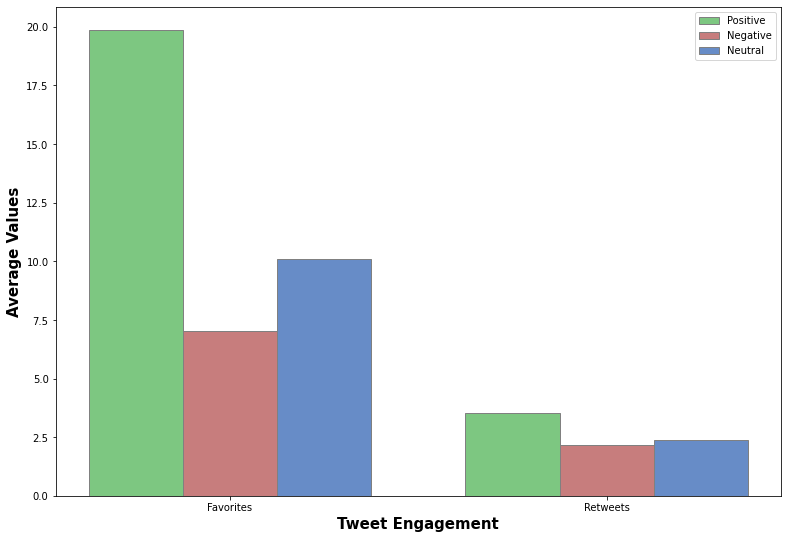

In [14]:
# Question 2 Sub-question vi)

posFavor, negFavor, neuFavor = 0, 0, 0
posRetweets, negRetweets, neuRetweets = 0, 0, 0

# For every tweet check its sentiment and the number of favorites and retweets it has
for row in df.itertuples():
  if row.sentiment == "pos":
    posFavor += int(row.favorites)
    posRetweets += int(row.retweets)
  if row.sentiment == "neg":
    negFavor += int(row.favorites)
    negRetweets += int(row.retweets)
  if row.sentiment == "neu":
    neuFavor += int(row.favorites)
    neuRetweets += int(row.retweets)

# Find the average number of favorites and retweets that a positive, negative or neutral tweet gets
posFavorAvg = float(posFavor) / pos
posRetweetsAvg = float(posRetweets) / pos

negFavorAvg = float(negFavor) / neg
negRetweetsAvg = float(negRetweets) / neg

neuFavorAvg = float(neuFavor) / neut
neuRetweetsAvg = float(neuRetweets) / neut

# Create a bar plot to show the average number of favorites and retweets
fig = plt.subplots(figsize =(13, 9))

posEngagement = [posFavorAvg, posRetweetsAvg]
negEngagement = [negFavorAvg, negRetweetsAvg]
neuEngagement = [neuFavorAvg, neuRetweetsAvg]

br = np.arange(len(posEngagement))

plt.bar(br, posEngagement, color ='#7dc781', width = 0.25, edgecolor ='grey', label ='Positive')
plt.bar(br + 0.25, negEngagement, color ='#c77d7d', width = 0.25, edgecolor ='grey', label ='Negative')
plt.bar(br + 0.50, neuEngagement, color ='#678cc7', width = 0.25, edgecolor ='grey', label ='Neutral')

plt.xlabel('Tweet Engagement', fontweight ='bold', fontsize = 15)
plt.ylabel('Average Values', fontweight ='bold', fontsize = 15)
plt.xticks(br + 0.25, ['Favorites', 'Retweets'])
 
plt.legend()
plt.show()

<h3><b> Number of negative tweets posted each month </b></h3>
We compare the number of negative tweets for every month.

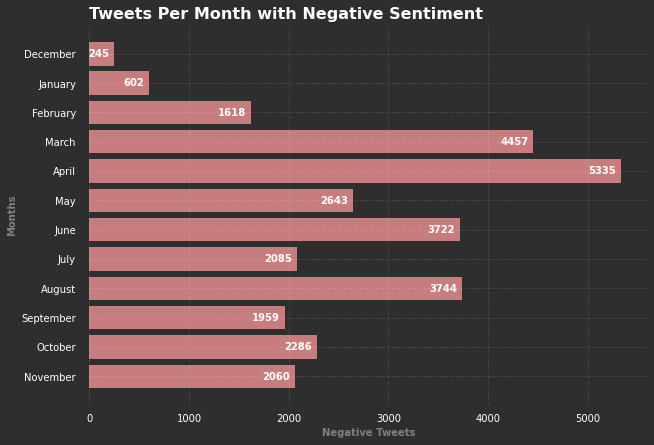

In [15]:
# Question 2 Sub-question vi)

count = 0
resultsList = [0]*12
i = 0

# Function that takes a list and increases the value of a specific index by one
def dynamicAppendList(lista, index, value):
  if not lista:
    lista[index] = value
  else:
    lista[index] = lista[index] + value
  return lista

# For each month we count all the tweets
for row in df.itertuples():
  if row.sentiment == "neg":
    date_time_formated = row.date.replace("-", "/")
    date_time = datetime.strptime(date_time_formated, '%Y/%m/%d %H:%M:%S')
    res = dynamicAppendList(resultsList, date_time.month-1, 1);
  
# Create a list with all the months
months = []
for month in calendar.month_name:
  if not month:
    continue
  months.append(month)

# Create a dictionary with keys and values of months and tweets 
resDict = {}
for key in months:
    for value in res:
        resDict[key] = value
        res.remove(value)
        break

lst = list(resDict.values())[-1] # Keep last value
resDict.popitem() # Remove December
Dict = {"December" : lst} 
Dict.update(resDict) # Make December the first one

# Create a bar plot that shows all the negative tweets for each month
BarGraphFunction(10, 7, list(Dict.values()), list(Dict.keys()), "Tweets Per Month with Negative Sentiment", "#c77d7d", "Negative Tweets", "Months")

-----

<h2><b> 3. Vectorization </b></h2>
<h3><b> Bag-of-words </b></h3>


In [16]:
# Get a list of the tweets from the training and test set
tweets_train_list = tf_train['text'].tolist()
tweets_test_list = tf_test['text'].tolist()

# Create a bag-of-words representation of the tweets
bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=1000, stop_words='english')

bow_xtrain = bow_vectorizer.fit_transform(tweets_train_list)
bow_xtest = bow_vectorizer.fit_transform(tweets_test_list)

# Convert the results to dataframes
bow_train_df = pd.DataFrame(bow_xtrain.toarray())
bow_test_df = pd.DataFrame(bow_xtest.toarray())

<h3><b> Tf-idf </b></h3>





In [17]:
# Create a Tf-idf representation of the tweets
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000, stop_words='english')

tfidf_xtrain = tfidf_vectorizer.fit_transform(tweets_train_list)
tfidf_xtest = tfidf_vectorizer.fit_transform(tweets_test_list)

# Convert the results to dataframes
tfidf_train_df = pd.DataFrame(tfidf_xtrain.toarray())
tfidf_test_df = pd.DataFrame(tfidf_xtest.toarray())

<h3><b> Word embeddings </b></h3>

In [18]:
model_wemb = {}

# Read the file with the pre-trained word vectors
with open("/content/drive/MyDrive/ΤΕΔΕ/glove.twitter.27B.100d.txt",'r') as f:
    for line in f:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        model_wemb[word] = embedding

In [19]:
tweets_train_wemb = np.zeros(shape=(len(tf_train), 100))
tweets_test_wemb = np.zeros(shape=(len(tf_test), 100))

# For every tweet this function calculates the average of the vectors of the words present in the tweet
def word_emb(dtf, tweets_wemb, model_wemb):
  i = 0

  for tweet in dtf['text']:
    tweet_vector = np.zeros(shape=(100,))
    num_words = 0
    split_tweet = tweet.split()

    # Check if the word exists in the pre-trained word vectors
    for word in split_tweet:
      if word in model_wemb:
        tweet_vector = tweet_vector + model_wemb[word]
        num_words += 1
    
    if num_words != 0:
      tweet_vector = tweet_vector / num_words
    
    tweets_wemb[i] = tweet_vector

    i += 1

# Get the word vectors for all the tweets in the training and test sets
word_emb(tf_train, tweets_train_wemb, model_wemb)
word_emb(tf_test, tweets_test_wemb, model_wemb)



------
## <b> 4. Classifying tweets </b>
We will use 3 different classifiers in order to predict the sentiment of the tweets in the dataset.


### <b> SVM </b>
The first method that we are going to use is the SVM classifier.
<br>
We will train a model using this algorithm and we will assess its predictions on the test set.

In [22]:
# Using the SVM classifier with a 'bag-of-words' representation of the dataset
cross_bow_svm = svm.SVC(gamma=0.001, C=100.)

# Perform cross validation
kf = KFold(n_splits=10, random_state=None)

scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro',
           'f1': 'f1_macro'}

all_scores = [0]*9

scores = cross_validate(cross_bow_svm , bow_train_df[:12000], tf_train['sentiment'][:12000], cv = kf, scoring=scoring)

print("Average Cross Validation Scores for Bag-of-words SVM Classifier")
print("Average Accuracy: ", scores['test_acc'].mean())
print("Average Precision: ", scores['test_prec'].mean())
print("Average Recall: ", scores['test_rec'].mean())
print("Average F1: ", scores['test_f1'].mean())

Average Cross Validation Scores for Bag-of-words SVM Classifier
Average Accuracy:  0.7617499999999999
Average Precision:  0.740932116062598
Average Recall:  0.5756325071732359
Average F1:  0.6109204006095711


In [23]:
# Train the model and perform predictions
bow_svm = svm.SVC(gamma=0.001, C=100.)
bow_svm.fit(bow_train_df, tf_train['sentiment'])
bow_svm_pred = bow_svm.predict(bow_test_df)

# Print all the important metrics
print("Classification Report for SVM Classifier with Bag-of-words")
print(classification_report(tf_test['sentiment'], bow_svm_pred, digits=3))
all_scores[0] = accuracy_score(tf_test['sentiment'], bow_svm_pred)

Classification Report for SVM Classifier with Bag-of-words
              precision    recall  f1-score   support

         neg      0.155     0.120     0.135      1463
         neu      0.664     0.813     0.731      6107
         pos      0.163     0.053     0.080      1559

    accuracy                          0.572      9129
   macro avg      0.327     0.329     0.316      9129
weighted avg      0.497     0.572     0.524      9129



In [24]:
# Using the SVM classifier with a 'Tf-idf' representation of the dataset
tfidf_svm = svm.SVC(gamma=0.001, C=100.)

# Train the model and perform predictions
tfidf_svm.fit(tfidf_train_df, tf_train['sentiment'])
tfidf_svm_pred = tfidf_svm.predict(tfidf_test_df)

# Print all the important metrics
print("Classification Report for SVM Classifier with Tf-idf")
print(classification_report(tf_test['sentiment'], tfidf_svm_pred, digits=3))
all_scores[1] = accuracy_score(tf_test['sentiment'], tfidf_svm_pred)

Classification Report for SVM Classifier with Tf-idf
              precision    recall  f1-score   support

         neg      0.163     0.062     0.089      1463
         neu      0.666     0.891     0.762      6107
         pos      0.157     0.040     0.064      1559

    accuracy                          0.613      9129
   macro avg      0.329     0.331     0.305      9129
weighted avg      0.498     0.613     0.535      9129



In [25]:
# Using the SVM classifier with a 'word embeddings' representation of the dataset
wemb_svm = svm.SVC(gamma=0.001, C=100.)

# Train the model and perform predictions
wemb_svm.fit(tweets_train_wemb, tf_train['sentiment'])
wemb_svm_pred = wemb_svm.predict(tweets_test_wemb)

# Print all the important metrics
print("Classification Report for SVM Classifier with Word Embeddings")
print(classification_report(tf_test['sentiment'], wemb_svm_pred, digits=3))
all_scores[2] = accuracy_score(tf_test['sentiment'], wemb_svm_pred)

Classification Report for SVM Classifier with Word Embeddings
              precision    recall  f1-score   support

         neg      0.689     0.373     0.484      1463
         neu      0.768     0.937     0.844      6107
         pos      0.771     0.437     0.558      1559

    accuracy                          0.761      9129
   macro avg      0.743     0.582     0.629      9129
weighted avg      0.756     0.761     0.737      9129



### <b> Random Forest </b>
The second method that we are going to use is the Random Forest classifier.

In [26]:
# Using the Random Forests classifier with a 'bag-of-words' representation of the dataset
cross_bow_rf = RandomForestClassifier(n_estimators=100)

# Perform cross validation
kf = KFold(n_splits=10, random_state=None)

scores = cross_validate(cross_bow_rf , bow_train_df[:12000], tf_train['sentiment'][:12000], cv = kf, scoring=scoring)

print("Average Cross Validation Scores for Bag-of-words Random Forest Classifier")
print("Average Accuracy: ", scores['test_acc'].mean())
print("Average Precision: ", scores['test_prec'].mean())
print("Average Recall: ", scores['test_rec'].mean())
print("Average F1: ", scores['test_f1'].mean())

Average Cross Validation Scores for Bag-of-words Random Forest Classifier
Average Accuracy:  0.7384166666666666
Average Precision:  0.6612788933627721
Average Recall:  0.6028662757409745
Average F1:  0.6216931605046974


In [27]:
# Train the model and perform predictions
bow_rf = RandomForestClassifier(n_estimators=100)
bow_rf.fit(bow_train_df, tf_train['sentiment'])
bow_rf_pred = bow_rf.predict(bow_test_df)

# Print all the important metrics
print("Classification Report for Random Forest with Bag-of-Words")
print(classification_report(tf_test['sentiment'], bow_rf_pred, digits=3))
all_scores[3] = accuracy_score(tf_test['sentiment'], bow_rf_pred)

Classification Report for Random Forest with Bag-of-Words
              precision    recall  f1-score   support

         neg      0.207     0.243     0.224      1463
         neu      0.670     0.709     0.689      6107
         pos      0.150     0.092     0.114      1559

    accuracy                          0.529      9129
   macro avg      0.342     0.348     0.342      9129
weighted avg      0.507     0.529     0.516      9129



In [28]:
# Using the Random Forests classifier with a 'Tf-idf' representation of the dataset
tfidf_rf = RandomForestClassifier(n_estimators=100)

# Train the model and perform predictions
tfidf_rf.fit(tfidf_train_df, tf_train['sentiment'])
tfidf_rf_pred = tfidf_rf.predict(tfidf_test_df)

# Print all the important metrics
print("Classification Report for Random Forest with Tf-idf")
print(classification_report(tf_test['sentiment'], tfidf_rf_pred, digits=3))
all_scores[4] = accuracy_score(tf_test['sentiment'], tfidf_rf_pred)

Classification Report for Random Forest with Tf-idf
              precision    recall  f1-score   support

         neg      0.202     0.145     0.169      1463
         neu      0.663     0.801     0.726      6107
         pos      0.144     0.065     0.089      1559

    accuracy                          0.570      9129
   macro avg      0.336     0.337     0.328      9129
weighted avg      0.501     0.570     0.528      9129



In [29]:
# Using the Random Forests classifier with a 'word embeddings' representation of the dataset
wemb_rf = RandomForestClassifier(n_estimators=100)

# Train the model and perform predictions
wemb_rf.fit(tweets_train_wemb, tf_train['sentiment'])
wemb_rf_pred = wemb_rf.predict(tweets_test_wemb)

# Print all the important metrics
print("Classification Report for Random Forest with Word Embeddings")
print(classification_report(tf_test['sentiment'], wemb_rf_pred, digits=3))
all_scores[5] = accuracy_score(tf_test['sentiment'], wemb_rf_pred)

Classification Report for Random Forest with Word Embeddings
              precision    recall  f1-score   support

         neg      0.724     0.281     0.405      1463
         neu      0.737     0.963     0.835      6107
         pos      0.802     0.297     0.434      1559

    accuracy                          0.740      9129
   macro avg      0.754     0.514     0.558      9129
weighted avg      0.746     0.740     0.697      9129



### <b> KNN </b>
The third and final method that we are going to use is the K-Nearest Neighbors classifier.

In [30]:
# Using the KNN classifier with a 'bag-of-words' representation of the dataset
cross_bow_knn = KNeighborsClassifier(n_neighbors = 10, weights="distance")

# Perform cross validation
kf = KFold(n_splits=10, random_state=None)

scores = cross_validate(cross_bow_knn , bow_train_df[:12000], tf_train['sentiment'][:12000], cv = kf, scoring=scoring)

print("Average Cross Validation Scores for Bag-of-words KNN Classifier")
print("Average Accuracy: ", scores['test_acc'].mean())
print("Average Precision: ", scores['test_prec'].mean())
print("Average Recall: ", scores['test_rec'].mean())
print("Average F1: ", scores['test_f1'].mean())

Average Cross Validation Scores for Bag-of-words KNN Classifier
Average Accuracy:  0.6850833333333333
Average Precision:  0.6493920789333859
Average Recall:  0.40990026197805907
Average F1:  0.4103429189465778


In [31]:
# Train the model and perform predictions
bow_knn = KNeighborsClassifier(n_neighbors = 10, weights="distance")
bow_knn.fit(bow_train_df, tf_train['sentiment'])
bow_knn_pred = bow_knn.predict(bow_test_df)

# Print all the important metrics
print("Classification Report for KNN with Bag-of-Words")
print(classification_report(tf_test['sentiment'], bow_knn_pred, digits=3))
all_scores[6] = accuracy_score(tf_test['sentiment'], bow_knn_pred)

Classification Report for KNN with Bag-of-Words
              precision    recall  f1-score   support

         neg      0.215     0.053     0.085      1463
         neu      0.669     0.944     0.783      6107
         pos      0.134     0.013     0.023      1559

    accuracy                          0.642      9129
   macro avg      0.339     0.337     0.297      9129
weighted avg      0.505     0.642     0.541      9129



In [32]:
# Using the KNN classifier with a 'Tf-idf' representation of the dataset
tfidf_knn = KNeighborsClassifier(n_neighbors = 10, weights="distance")

# Train the model and perform predictions
tfidf_knn.fit(bow_train_df, tf_train['sentiment'])
tfidf_knn_pred = tfidf_knn.predict(tfidf_test_df)

# Print all the important metrics
print("Classification Report for KNN with Tf-idf")
print(classification_report(tf_test['sentiment'], tfidf_knn_pred, digits=3))
all_scores[7] = accuracy_score(tf_test['sentiment'], tfidf_knn_pred)

Classification Report for KNN with Tf-idf
              precision    recall  f1-score   support

         neg      0.196     0.021     0.038      1463
         neu      0.670     0.973     0.793      6107
         pos      0.180     0.012     0.022      1559

    accuracy                          0.656      9129
   macro avg      0.349     0.335     0.284      9129
weighted avg      0.510     0.656     0.541      9129



In [33]:
# Using the KNN classifier with a 'word embeddings' representation of the dataset
wemb_knn = KNeighborsClassifier(n_neighbors = 10, weights="distance")

# Train the model and perform predictions
wemb_knn.fit(tweets_train_wemb, tf_train['sentiment'])
wemb_knn_pred = wemb_knn.predict(tweets_test_wemb)

# Print all the important metrics
print("Classification Report for KNN with Word Embeddings")
print(classification_report(tf_test['sentiment'], wemb_knn_pred, digits=3))
all_scores[8] = accuracy_score(tf_test['sentiment'], wemb_knn_pred)

Classification Report for KNN with Word Embeddings
              precision    recall  f1-score   support

         neg      0.577     0.438     0.498      1463
         neu      0.781     0.884     0.829      6107
         pos      0.651     0.461     0.539      1559

    accuracy                          0.740      9129
   macro avg      0.670     0.594     0.622      9129
weighted avg      0.726     0.740     0.727      9129



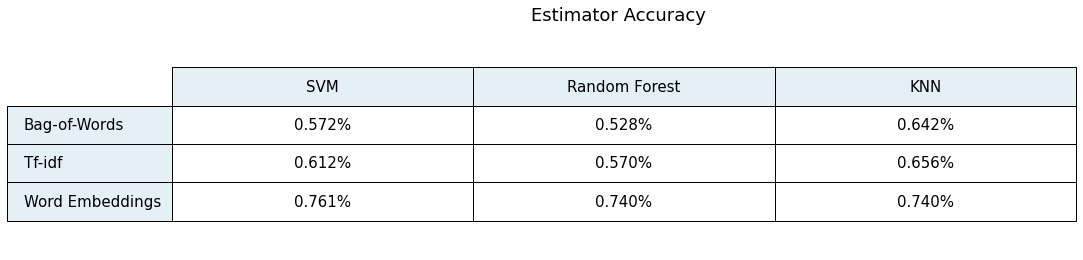

In [35]:
# Create a list with all the scores that will be printed
final_scores = []
for i in range(9):
  final_scores.append(str(all_scores[i]))
  final_scores[i] = final_scores[i][:5]
  final_scores[i] = final_scores[i] + "%"

# Create a table with the accuracy scores of each estimator
cell_text = [[final_scores[0], final_scores[3], final_scores[6]],
             [final_scores[1], final_scores[4], final_scores[7]],
             [final_scores[2], final_scores[5], final_scores[8]]]

table_col = ('SVM', 'Random Forest', 'KNN')
table_rows = ['Bag-of-Words', 'Tf-idf', 'Word Embeddings']

row_colors = plt.cm.BuPu(np.full(len(table_rows), 0.1))
col_colors = plt.cm.BuPu(np.full(len(table_col), 0.1))

the_table = plt.table(cellText=cell_text,
                      rowLabels=table_rows,
                      rowColours=row_colors,
                      colLabels=table_col,
                      colColours=col_colors,
                      cellLoc='center',
                      loc='center')

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

the_table.auto_set_font_size(False)
the_table.set_fontsize(15)

plt.suptitle('Estimator Accuracy', fontsize=18)
the_table.scale(2.7, 3.2)

As we can see from the scores above, the Word Embeddings representation of the tweets has the best accuracy on every estimator, followed by Tf-idf and then Bag-of-Words which is the expected result.
<br>
SVM achieved the best accuracy out of every estimator. Random Forest and KNN performed similarly with Word Embeddings, but KNN had much better accuracy with Bag-of-Words and Tf-idf compared to Random Forest.

---

## <b> 5. Topic modeling using Latent Dirichlet Allocation </b>
First we follow the initial steps of preprocessing the tweets:
<br>
<p>Tokenizing &#8594 Stop word removal &#8594 Lemmatization &#8594 Stemming &#8594 Bag-of-words</p>

In [37]:
sentence = ""

# Getting the 'text' column words into a string.
for row in df.itertuples():
  sentence = sentence + row.text

# Replace any double space with a single space
sentence = sentence.replace('  ', ' ')

# Tokenize text
words = nltk.word_tokenize(sentence)

lem = WordNetLemmatizer()
ps = PorterStemmer()

# Lemmatization
# Stemming
index = 0
for word in words:
  words[index] = lem.lemmatize(word)
  words[index] = ps.stem(word)
  index += 1

In [38]:
# Get the bag-of-words representation of the words
texts = words
id2word = corpora.Dictionary([texts])
corpus = [id2word.doc2bow(texts)]

Now we have to create LDA models with a different number of topics and comapre their coherence scores

In [39]:
num_topics_dict = {}

# Make LDA models with different number of topics and get their coherence score
for i in range(10, 21):

  # LDA model
  lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=i)

  # Get Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=[words], dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  num_topics_dict[i] = coherence_lda

We graph the all the different topic numbers and their coherence scores to find the optimal number of topics

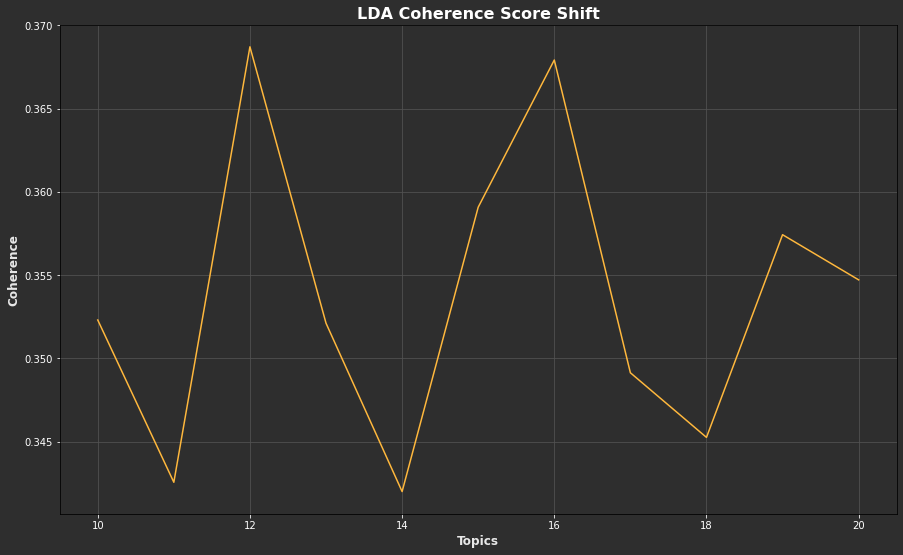

In [40]:
# Get the number of topics and the corresponding coherence scores from the dictionary
myList = num_topics_dict.items()
myList = sorted(myList) 
x, y = zip(*myList) 

# Create a graph to see how the number of topics affect the coherence score
fig, ax = plt.subplots(figsize =(15, 9))
  
ax.set_facecolor('#2e2e2e')
ax.tick_params(colors='white', which='both')
fig.patch.set_facecolor('#2e2e2e')

ax.set_title("LDA Coherence Score Shift", fontsize=16, loc ='center', fontweight ='bold' , color='white')
plt.xlabel("Topics", fontweight ='bold',  fontsize=12, color='#e8e8e8')
plt.ylabel("Coherence", fontweight ='bold', fontsize=12, color='#e8e8e8')
plt.plot(x, y, color='#ffb83d')
plt.grid(color='#525252')

plt.show()

Finally we visualize the results from the LDA model we picked using pyLDAvis

In [41]:
# Get the optimal number of topics
max_key = max(num_topics_dict, key=num_topics_dict.get)

# Creating an optimized model
optimized_lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=max_key)

# Get Coherence Score, using the best model number found in the previous block.
coherence_model_lda = CoherenceModel(model=optimized_lda_model, texts=[words], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

# Visualize result
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimized_lda_model, corpus, dictionary=optimized_lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.003770  0.001152       1        1  35.488973
2      0.003203 -0.001907       2        1  30.034347
9      0.002056  0.002150       3        1  12.053182
4      0.001926 -0.001748       4        1  11.474868
0      0.000139 -0.000199       5        1   2.925004
8      0.001046 -0.000873       6        1   2.817329
6     -0.000031  0.000297       7        1   2.339040
3     -0.000648  0.000021       8        1   1.784512
7     -0.001326  0.002165       9        1   0.511870
1     -0.003266 -0.000752      10        1   0.277114
5     -0.002047  0.000221      11        1   0.256912
11    -0.004821 -0.000527      12        1   0.036848, topic_info=         Term          Freq         Total Category  logprob  loglift
60683  vaccin  71932.000000  71932.000000  Default  30.0000  30.0000
26952    dose  44886.000000  44886.000000  Default  29.0000  29.0000
54713    slot  36733.000000  36733.000000  Default  28.0000  28.0000
15704     age  35290.000000  35290.000000  Default  27.0000  27.0000
6869       18  21789.000000  21789.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
48059  pincod      3.553712  12861.131715  Topic12  -5.3641  -0.2879
5193     1410      2.527286   7590.056790  Topic12  -5.7049  -0.1013
58417   today      2.942508  10028.066997  Topic12  -5.5528  -0.2278
16525     amp      2.607558   8933.343172  Topic12  -5.6736  -0.2330
31133   first      2.800650  13880.109044  Topic12  -5.6022  -0.6023

[1115 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
0          1  0.327278     0
0          2  0.304554     0
0          3  0.120182     0
0          4  0.135409     0
0          5  0.026473     0
...      ...       ...   ...
64481      5  0.038284  zone
64481      6  0.019142  zone
64481      7  0.019142  zone
64481      8  0.019142  zone
64481      9  0.009571  zone

[4276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 3, 10, 5, 1, 9, 7, 4, 8, 2, 6, 12])

## <b> 6. Beat the Benchmark </b>

In [42]:
# Read the .pkl file again
bench_df = pd.read_pickle('/content/drive/MyDrive/ΤΕΔΕ/eclass_all_with_sentiment_v2.pkl')
bench_df2 = bench_df.iloc[:df_size]

favorList, retweetList, urlList, mentionList, lowerList, upperList, exclList, questList, quotList = ([] for i in range(9))

# Extract extra features from the dataset.
# From each tweet find the number of favorites, retweets, URLs, mentions ('@'), lowercase and uppercase letters
# and the number of exclamation marks('!'), question marks ('?') and quotation marks (")
for row in bench_df2.itertuples():
  
  # Get the number of favorites, retweets, URLs and mentions
  favorList.append(int(row.favorites))
  retweetList.append(int(row.retweets))
  urlList.append(row.text.count("http"))
  mentionList.append(row.text.count('@'))

  # Get the number of lowercase and uppercase letters excluding the URLs
  tweet = row.text
  url = [word for word in tweet.split() if word.startswith("http")]
  for link in url:
    tweet = tweet.replace(link,'')

  lowerList.append(sum(map(str.islower, tweet)))
  upperList.append(sum(map(str.isupper, tweet)))

  # Get the number of '!', '?' and quotation marks
  exclList.append(row.text.count('!'))
  questList.append(row.text.count('?'))
  quotList.append(row.text.count('\"'))

In [48]:
tweets_train_lemmatized = []
tweets_test_lemmatized = []
temp_train = ""
temp_test = ""
i = 0

# Perform lemmatization on the dataset
for tweet in tweets_train_list:
  for word in tweet.split():
    temp_train += lem.lemmatize(word) + " "
  tweets_train_lemmatized.append(temp_train)
  temp_train = ""
  

for tweet in tweets_test_list:
  for word in tweet.split():
    temp_test += lem.lemmatize(word) + " "
  tweets_test_lemmatized.append(temp_test)
  temp_test = ""

In [49]:
# We will use word embeddings to train the final model

tweets_train_df = pd.DataFrame()
tweets_test_df = pd.DataFrame()
tweets_train_wemb = np.zeros(shape=(len(tf_train), 100))
tweets_test_wemb = np.zeros(shape=(len(tf_test), 100))

tweets_train_df['text'] = tweets_train_lemmatized
tweets_test_df['text'] = tweets_test_lemmatized

# Get the word vectors for all the tweets in the training and test sets
word_emb(tweets_train_df, tweets_train_wemb, model_wemb)
word_emb(tweets_test_df, tweets_test_wemb, model_wemb)

In [50]:
# Function that finds the best parameters for a given estimator using grid search with cross validation
def gridSearch(title, model, parameters, X , y):
  
  scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
  kf = KFold(n_splits=10, random_state=None)

  # Find the best parameters
  clf = GridSearchCV(model, param_grid=parameters, scoring=scoring, cv=kf, refit='accuracy')
  clf.fit(X, y)
  
  # Get the mean scores of the best estimator
  bestModel_accuracy = clf.cv_results_['mean_test_accuracy'][clf.best_index_]
  bestModel_precision = clf.cv_results_['mean_test_precision_macro'][clf.best_index_]
  bestModel_recall = clf.cv_results_['mean_test_recall_macro'][clf.best_index_]
  bestModel_f1 = clf.cv_results_['mean_test_f1_macro'][clf.best_index_]

  print(title)
  print("Avg accuracy: ", bestModel_accuracy)
  print("Avg precision: ", bestModel_precision)
  print("Avg recall: " ,bestModel_recall)
  print("Avg f1: ", bestModel_f1)
  print("Best parameters: ", clf.best_params_)

  return clf.best_params_

In [51]:
# Convert the word embedding numpy arrays to dataframes
df_train = pd.DataFrame(tweets_train_wemb)
df_test = pd.DataFrame(tweets_test_wemb)

# Add the feature columns to the dataframes
df_train['favorites'], df_test['favorites'] = favorList[:train_size], favorList[train_size:]
df_train['retweets'], df_test['retweets'] = retweetList[:train_size], retweetList[train_size:]
df_train['urls'], df_test['urls'] = urlList[:train_size], urlList[train_size:]
df_train['mentions'], df_test['mentions'] = mentionList[:train_size], mentionList[train_size:]
df_train['lowercase'], df_test['lowercase'] = lowerList[:train_size], lowerList[train_size:]
df_train['uppercase'], df_test['uppercase'] = upperList[:train_size], upperList[train_size:]
df_train['exclamations'], df_test['exclamations'] = exclList[:train_size], exclList[train_size:]
df_train['questions'], df_test['questions'] = questList[:train_size], questList[train_size:]
df_train['quotes'], df_test['quotes'] = quotList[:train_size], quotList[train_size:]

parameters = {
    "n_estimators": [100, 200, 400],
    "criterion" :['gini', 'entropy'],
    "max_features": ['auto', 'sqrt', 'log2']
}

In [52]:
# Perform cross validation and find best parameters
best_param_dict = gridSearch("Average Cross Validation Scores for Word Embeddings Random Forest Classifier",
                              RandomForestClassifier(), parameters, df_train[:10000], tf_train['sentiment'][:10000])

Average Cross Validation Scores for Word Embeddings Random Forest Classifier
Avg accuracy:  0.7280000000000001
Avg precision:  0.7764644650595506
Avg recall:  0.489883784798132
Avg f1:  0.519174007553681
Best parameters:  {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}


In [53]:
# Train the model and perform predictions
bench_clf = RandomForestClassifier(n_estimators=best_param_dict['n_estimators'], criterion=best_param_dict['criterion'], max_features=best_param_dict['max_features'])
bench_clf.fit(df_train, tf_train['sentiment'])
bench_pred = bench_clf.predict(df_test)

# Print all the important metrics
print("Classification Report for Random Forest with Word Embeddings")
print(classification_report(tf_test['sentiment'], bench_pred, digits=3))

Classification Report for Random Forest with Word Embeddings
              precision    recall  f1-score   support

         neg      0.755     0.280     0.408      1463
         neu      0.738     0.965     0.836      6107
         pos      0.787     0.303     0.438      1559

    accuracy                          0.742      9129
   macro avg      0.760     0.516     0.561      9129
weighted avg      0.749     0.742     0.699      9129

